# Feasible Space for 3 valid Dubins Car CBFs

The Dubins car problem is non-holonomic, and while each configuration is possible, the manner in which those configurations can be reached is reduced. Notably we have $$\dot y \cos \theta - \dot x \sin \theta = 0$$

Hence, unlike for the other examples we cannot rely on the linearized LQR controller to act as performance / nominal controller. Instead we solve the reachability problem for reaching a target (without accounting for the obstacle avoidance) and use the found policy as the performance policy.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.version

'3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'

In [3]:
import sys
# sys.path.append('/home/dasc/hardik/social-navigation/refineCBF')
sys.path.append('/home/hardik/Desktop/Research/social-navigation/refineCBF')
# sys.path.append('/home/refineCBF')
sys.path.append('/home/cps/Research/social-navigation/refineCBF')

In [4]:
name = 'valid_conservative_'

In [5]:
import refine_cbfs
from cbf_opt import ControlAffineDynamics, ControlAffineCBF, ControlAffineASIF
import matplotlib.pyplot as plt
import hj_reachability as hj
import jax
import jax.numpy as jnp
from jax import jit
import numpy as np
import seaborn as sns
from experiment_wrapper import RolloutTrajectory, TimeSeriesExperiment, StateSpaceExperiment
from dubins import nominal_hjr_control
%matplotlib widget


In [6]:
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '50',
    'text.usetex': False,   # Toggle to true for official LaTeX output
    'pgf.rcfonts': False,
    'lines.linewidth': 6.,
})
import matplotlib.animation as anim

params = {'axes.labelsize': 28,'axes.titlesize':28, 'font.size': 28, 'legend.fontsize': 28, 
          'xtick.labelsize': 28, 'ytick.labelsize': 28, 'lines.linewidth': 5}
matplotlib.rcParams.update(params)

## Setup Problem (dynamics, environment and CBF)

### Parameter values

Dynamics properties

In [7]:
dubins_vel = 0.3  # m / s 
umin = np.array([-0.7])  # rad / s
umax = np.array([0.7])  # rad / s 
dt = 0.05 # s

Constraint set of the problem. Single rectangular constraint in the $(x,y)$ space

### Dynamics

Dynamics of the Dubins car problem (control affine), with fixed velocity $v$ in the format of `cbf_opt`

`DubinsJNPDynamics` is required for usage with `hj_reachability` module

In [8]:
class DubinsDynamics(ControlAffineDynamics):
    STATES = ['X', 'Y', 'THETA']
    CONTROLS = ['OMEGA']
    
    def __init__(self, params, test = False, **kwargs):
        params['n_dims'] = 3
        params['control_dims'] = 1
        params["periodic_dims"] = [2]
        self.v = params["v"]
        super().__init__(params, test, **kwargs)

    def open_loop_dynamics(self, state, time=0.0):
        f = np.zeros_like(state)
        f[..., 0] = self.v * np.cos(state[..., 2])
        f[..., 1] = self.v * np.sin(state[..., 2])
        return f

    def control_matrix(self, state, time=0.0):
        B = np.repeat(np.zeros_like(state)[..., None], self.control_dims, axis=-1)
        B[..., 2, 0] = 1
        return B

    def disturbance_jacobian(self, state, time=0.0):
        return np.repeat(np.zeros_like(state)[..., None], 1, axis=-1)

    def state_jacobian(self, state, control, time=0.0):
        J = np.repeat(np.zeros_like(state)[..., None], self.n_dims, axis=-1)
        J[..., 0, 2] = -self.v * np.sin(state[..., 2])
        J[..., 1, 2] = self.v * np.cos(state[..., 2])
        return J
        
class DubinsJNPDynamics(DubinsDynamics):
    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([self.v * jnp.cos(state[2]), self.v * jnp.sin(state[2]), 0])

    def control_matrix(self, state, time=0.0):
        return jnp.expand_dims(jnp.array([0, 0, 1]), axis=-1)

    def disturbance_jacobian(self, state, time=0.0):
        return jnp.expand_dims(jnp.zeros(3), axis=-1)

    def state_jacobian(self, state, control, time=0.0):
        return jnp.array([
            [0, 0, -self.v * jnp.sin(state[2])],
            [0, 0, self.v * jnp.cos(state[2])], 
            [0, 0, 0]])

In [9]:
dyn = DubinsDynamics({"v": dubins_vel, "dt": dt}, test=True)
dyn_jnp = DubinsJNPDynamics({"v": dubins_vel, "dt": dt}, test=True)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### Initial Control Barrier Function

Below is a candidate CBF, however as the Dubins car with obstacles in $x,y$ has relative degree $2$, the CBF cannot be enforced online as the CBF constraint does not feature the input (steering rate)

This CBF inflate the rectangular obstacle to a circle obstacle, as is typically done to preserve convexity

### Environment
Defining the discretized state space and the location of obstacles

In [10]:
dyn_hjr = refine_cbfs.dynamics.HJControlAffineDynamics(dyn_jnp, control_space=hj.sets.Box(jnp.array(umin), jnp.array(umax)))

state_domain = hj.sets.Box(lo=jnp.array([0., 0., -jnp.pi]), hi=jnp.array([4., 4., jnp.pi]))
# grid_resolution = (201, 201, 81)
grid_resolution = (101, 101, 64)
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(state_domain, grid_resolution, periodic_dims=2)

In [11]:
d_min = 0.5

@jit
def obstacle_barrier(robotX, obsX):
        h = (robotX[0] - obsX[0])*(robotX[0] - obsX[0]) + (robotX[1] - obsX[1])*(robotX[1] - obsX[1]) - d_min**2
        
        h_dot = 2*(robotX[0] - obsX[0])*dubins_vel*jnp.cos(robotX[2]) + 2*(robotX[1] - obsX[1])*dubins_vel*jnp.sin(robotX[2])
        dh_dot_dx = jnp.array( [ 2*dubins_vel*jnp.cos(robotX[2]), 2*dubins_vel*jnp.sin(robotX[2]), 2*(robotX[0] - obsX[0])*dubins_vel*(-jnp.sin(robotX[2]))+2*(robotX[1] - obsX[1])*dubins_vel*(jnp.cos(robotX[2])) ] )
        # dh_dx = 2 * jnp.array([robotX[0] - obsX[0], robotX[1] - obsX[1], 0.0 ])
        # print(f"h: {h}, dh_dot_dx:{dh_dot_dx}")
        return h, h_dot, dh_dot_dx.reshape(1,-1)

def robot_f(robotX):
    return jnp.array([ dubins_vel*jnp.cos(robotX[2]), dubins_vel*jnp.sin(robotX[2]), 0.0 ]).reshape(-1,1)

def robot_g(robotX):
    return jnp.array([ 0.0, 0.0, 1.0  ]).reshape(-1,1)

alpha1 = 0.7#0.8#0.8#1.5
alpha2 = 1.0#1.0#1.5#3.0
key = jax.random.PRNGKey(10)
num_samples = 500 #1000
samples = jax.random.uniform( key, shape=(1,num_samples), minval=umin, maxval=umax )#A.shape[1]   

@jit
def mc_polytope_volume(A, b):
    aux = A @ samples - b    
    aux = -aux
    aux = jnp.min(aux, axis=0)
    aux = (jnp.tanh( aux / 0.0000001 ) + 1.0)/2.0
    aux = jnp.sum( aux )
    vol = (umax-umin) * (aux / num_samples)
    return vol

control_bound_polytope_A = jnp.array([ 1.0, -1.0 ]).reshape(-1,1)
control_bound_polytope_b = jnp.array([ umax, umax ]).reshape(-1,1)

# # obstacles
obs1 = np.array([2.0,2.0])
obs2 = np.array([1.0,3.0])
obs3 = np.array([2.7,3.0])

@jit
def constraint_compute(state):

    # CBF conditions
    h1, h1_dot, dh1_dot_dx = obstacle_barrier( state, obs1 )
    h2, h2_dot, dh2_dot_dx = obstacle_barrier( state, obs2 )
    h3, h3_dot, dh3_dot_dx = obstacle_barrier( state, obs3 )

    # Robot f and g matrices
    gx = robot_g(state)
    fx = robot_f(state)
    
    # Ax >= b 
    A1 = dh1_dot_dx @ gx
    b1 = - dh1_dot_dx @ fx  - (alpha2 + alpha1) * h1_dot - alpha1 * alpha2 * h1

    A2 = dh2_dot_dx @ gx
    b2 = - dh2_dot_dx @ fx  - (alpha2 + alpha1) * h2_dot - alpha1 * alpha2 * h2

    A3 = dh3_dot_dx @ gx
    b3 = - dh3_dot_dx @ fx  - (alpha2 + alpha1) * h3_dot - alpha1 * alpha2 * h3

    A = jnp.concatenate([-A1, -A2, -A3, control_bound_polytope_A], axis=0)
    b = jnp.concatenate([-b1, -b2, -b3, control_bound_polytope_b], axis=0)

    # print(f" alpha:{alpha}, \n gx:{gx}, \n fx:{fx} \n A:{A}, \n b:{b} ")

    violation = jnp.sign( jnp.min(jnp.array([h1, h2, h3])) )
    
    volume = mc_polytope_volume(A, b) 
    return jnp.min(jnp.array([h1, h2, h3])), volume, violation

@jit
def constraint_set(state):
    """A real-valued function s.t. the zero-superlevel set is the safe set

    Args:
        state : An unbatched (!) state vector, an array of shape `(4,)` containing `[y, v_y, phi, omega]`.

    Returns:
        A scalar, positive iff the state is in the safe set
    """
    h_min, volume, violation = constraint_compute(state)
    return jnp.min( jnp.array([ volume[0], 1000*jnp.sign(violation) ]) )

@jit
def constraint_set1(robotX):
    h = (robotX[0] - obs1[0])*(robotX[0] - obs1[0]) + (robotX[1] - obs1[1])*(robotX[1] - obs1[1]) - d_min**2
    return h

@jit
def constraint_set2(robotX):
    h = (robotX[0] - obs2[0])*(robotX[0] - obs2[0]) + (robotX[1] - obs2[1])*(robotX[1] - obs2[1]) - d_min**2
    return h

@jit
def constraint_set3(robotX):
    h = (robotX[0] - obs3[0])*(robotX[0] - obs3[0]) + (robotX[1] - obs3[1])*(robotX[1] - obs3[1]) - d_min**2
    return h



In [12]:
constraint_set( np.array([1.0, 1.0, 0.0]) )

Array(1.3272, dtype=float32)

In [13]:
heading = 46.67*np.pi/180#np.pi/4
x = np.linspace(0,4,grid.states.shape[0])
y = np.linspace(0,4,grid.states.shape[1])
X, Y = np.meshgrid(x,y)
volumes = np.zeros((grid.states.shape[0],grid.states.shape[1]))
hs = np.zeros((grid.states.shape[0],grid.states.shape[1]))
for j in range(grid.states.shape[0]):
    for k in range(grid.states.shape[1]):
        # hs[j,k], volumes[j,k] = constraint_set( np.array([ X[j,k], Y[j,k], heading ]) )
        volumes[j,k] = constraint_set1( np.array([ X[j,k], Y[j,k], heading ]) )

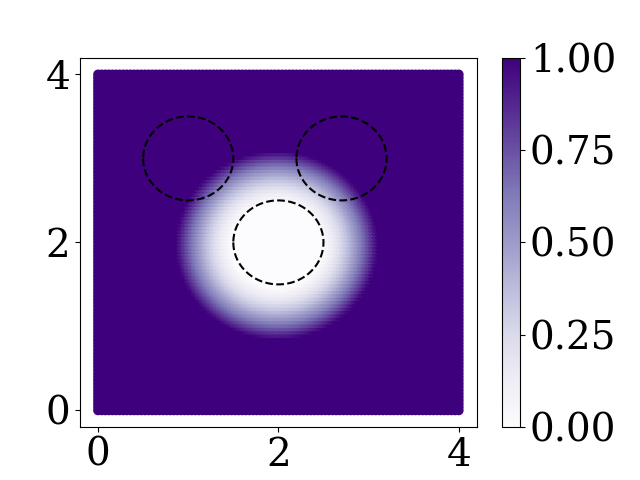

In [14]:


fig3, ax3 = plt.subplots()
im3 = ax3.scatter( X.reshape(-1,1), Y.reshape(-1,1), c = volumes.reshape(-1,1), cmap='Purples', vmin=0.0, vmax=1.0 )
fig3.colorbar(im3, ax=ax3)
theta = np.linspace(-np.pi, np.pi, 360)
ax3.plot( obs1[0]+0.5*np.cos(theta), obs1[1]+0.5*np.sin(theta), 'k--', linewidth=1.5 )
ax3.plot( obs2[0]+0.5*np.cos(theta), obs2[1]+0.5*np.sin(theta), 'k--', linewidth=1.5)
ax3.plot( obs3[0]+0.5*np.cos(theta), obs3[1]+0.5*np.sin(theta), 'k--', linewidth=1.5 )
fig3.savefig(name+'compatible_space.png')

# fig4, ax4 = plt.subplots()
# im4 = ax4.scatter( X.reshape(-1,1), Y.reshape(-1,1), c = hs.reshape(-1,1), cmap='jet', vmin=-1, vmax=3.0 )
# fig4.colorbar(im4, ax=ax4)
# theta = np.linspace(-np.pi, np.pi, 360)
# ax4.plot( obs1[0]+0.5*np.cos(theta), obs1[1]+0.5*np.sin(theta), 'k--', linewidth=1.5 )
# ax4.plot( obs2[0]+0.5*np.cos(theta), obs2[1]+0.5*np.sin(theta), 'k--', linewidth=1.5)
# ax4.plot( obs3[0]+0.5*np.cos(theta), obs3[1]+0.5*np.sin(theta), 'k--', linewidth=1.5 )
# plt.show()

In [15]:
# Just different colormap
# fig3, ax3 = plt.subplots()
# im3 = ax3.scatter( X.reshape(-1,1), Y.reshape(-1,1), c = volumes.reshape(-1,1), cmap='jet', vmin=-1, vmax=1.0 )
# fig3.colorbar(im3, ax=ax3)
# theta = np.linspace(-np.pi, np.pi, 360)
# ax3.plot( obs1[0]+0.5*np.cos(theta), obs1[1]+0.5*np.sin(theta), 'k--', linewidth=1.5 )
# ax3.plot( obs2[0]+0.5*np.cos(theta), obs2[1]+0.5*np.sin(theta), 'k--', linewidth=1.5)
# ax3.plot( obs3[0]+0.5*np.cos(theta), obs3[1]+0.5*np.sin(theta), 'k--', linewidth=1.5 )

# fig4, ax4 = plt.subplots()
# im4 = ax4.scatter( X.reshape(-1,1), Y.reshape(-1,1), c = hs.reshape(-1,1), cmap='jet', vmin=-1, vmax=3.0 )
# fig4.colorbar(im4, ax=ax4)
# theta = np.linspace(-np.pi, np.pi, 360)
# ax4.plot( obs1[0]+0.5*np.cos(theta), obs1[1]+0.5*np.sin(theta), 'k--', linewidth=1.5 )
# ax4.plot( obs2[0]+0.5*np.cos(theta), obs2[1]+0.5*np.sin(theta), 'k--', linewidth=1.5)
# ax4.plot( obs3[0]+0.5*np.cos(theta), obs3[1]+0.5*np.sin(theta), 'k--', linewidth=1.5 )
# plt.show()

In [22]:
constraint_set1(jnp.array([1.7,3.0,0.0]))

Array(0.8399999, dtype=float32)

In [29]:
obstacle = hj.utils.multivmap(constraint_set, jnp.arange(grid.ndim))(grid.states)  # l(x)
obstacle1 = hj.utils.multivmap(constraint_set1, jnp.arange(grid.ndim))(grid.states)  # l(x)
obstacle2 = hj.utils.multivmap(constraint_set2, jnp.arange(grid.ndim))(grid.states)  # l(x)
obstacle3 = hj.utils.multivmap(constraint_set3, jnp.arange(grid.ndim))(grid.states)  # l(x)

In [18]:
grid.states.shape

(101, 101, 64, 3)

## Refining the CBF using Dynamic Programming

In [21]:
constraint_set1

<PjitFunction of <function constraint_set1 at 0x7e4b745ca950>>

Classically, we solve the reachability problem by initializing the value function with the obstacle set, as below:

### Original constraint and volume

In [45]:
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("high", value_postprocessor=backwards_reachable_tube(obstacle))
init_value = obstacle
time = 0.
target_time = -10.
times = jnp.linspace(time, target_time, 101)

target_values_constraint = hj.solve(solver_settings, dyn_hjr, grid, times, init_value)
# np.save("dubins/hjr_vfs.npy", target_values_hjr)

100%|#######################################################################################################################| 10.0000/10.0 [03:05<00:00, 18.58s/sim_s]


In [48]:
tabular_cbf_constraint = refine_cbfs.TabularControlAffineCBF(dyn, grid=grid)
tabular_cbf_constraint.vf_table = np.array(target_values_constraint[-1])
jnp.min(tabular_cbf_constraint.vf_table)

Array(-1000.0001, dtype=float32)

### Obstacle 1

In [24]:
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("high", value_postprocessor=backwards_reachable_tube(obstacle1))
init_value = obstacle1
time = 0.
target_time = -10.
times = jnp.linspace(time, target_time, 101)
target_values_constraint1 = hj.solve(solver_settings, dyn_hjr, grid, times, init_value)
tabular_cbf_constraint1 = refine_cbfs.TabularControlAffineCBF(dyn, grid=grid)
tabular_cbf_constraint1.vf_table = np.array(target_values_constraint1[-1])
jnp.min(tabular_cbf_constraint1.vf_table)

100%|#######################################################################################################################| 10.0000/10.0 [02:37<00:00, 15.79s/sim_s]


Array(-0.25, dtype=float32)

### Obstacle 2

In [30]:
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("high", value_postprocessor=backwards_reachable_tube(obstacle2))
init_value = obstacle2
time = 0.
target_time = -10.
times = jnp.linspace(time, target_time, 101)
target_values_constraint2 = hj.solve(solver_settings, dyn_hjr, grid, times, init_value)
tabular_cbf_constraint2 = refine_cbfs.TabularControlAffineCBF(dyn, grid=grid)
tabular_cbf_constraint2.vf_table = np.array(target_values_constraint2[-1])
jnp.min(tabular_cbf_constraint2.vf_table)

100%|#######################################################################################################################| 10.0000/10.0 [02:37<00:00, 15.74s/sim_s]


Array(-0.25, dtype=float32)

### Obstacle 3

In [ ]:
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("high", value_postprocessor=backwards_reachable_tube(obstacle3))
init_value = obstacle3
time = 0.
target_time = -10.
times = jnp.linspace(time, target_time, 101)
target_values_constraint3 = hj.solve(solver_settings, dyn_hjr, grid, times, init_value)
tabular_cbf_constraint3 = refine_cbfs.TabularControlAffineCBF(dyn, grid=grid)
tabular_cbf_constraint3.vf_table = np.array(target_values_constraint3[-1])
jnp.min(tabular_cbf_constraint3.vf_table)

 27%|###############################9                                                                                       |  2.6846/10.0 [00:42<01:46, 14.50s/sim_s]

shape: (101, 101)


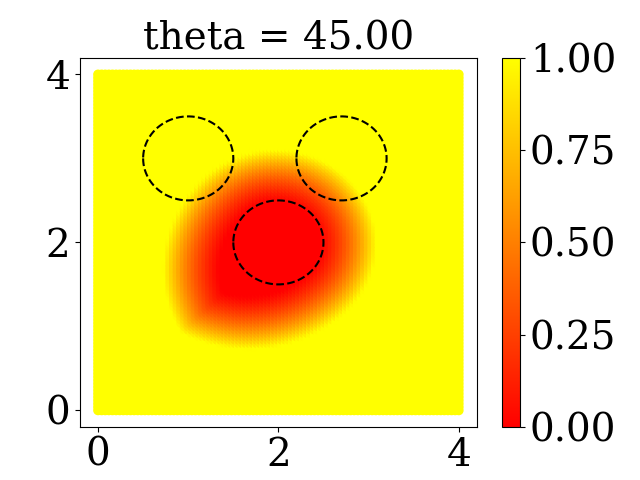

In [26]:
print(f"shape: {tabular_cbf_constraint.vf_table[:,:,0].shape}")
thetas_value = grid.states[0,1,:,2]
theta_index = int(grid.states.shape[2]/2/4 + grid.states.shape[2]/2) #51 # for 45 degrees
fig6, ax6 = plt.subplots()
ax6.set_title(f"theta = %.2f" %(thetas_value[theta_index]*180/np.pi))
x = np.linspace(0,4, grid.states.shape[0])
y = np.linspace(0,4, grid.states.shape[1]) # grid_resolution = (201, 201, 81)
X, Y = np.meshgrid(x,y)
im6 = ax6.scatter( Y.reshape(-1,1), X.reshape(-1,1), c = tabular_cbf_constraint.vf_table[:,:,theta_index].reshape(-1,1), cmap='autumn', vmin=0.0, vmax=1.0 )
# im6 = ax6.scatter( Y.reshape(-1,1), X.reshape(-1,1), c = tabular_cbf_hjr.vf_table[:,:,theta_index].reshape(-1,1), cmap='jet', vmin=-1, vmax=1.0 )
fig6.colorbar(im6, ax=ax6)
theta = np.linspace(-np.pi, np.pi, 360)
ax6.plot( obs1[0]+0.5*np.cos(theta), obs1[1]+0.5*np.sin(theta), 'k--', linewidth=1.5 )
ax6.plot( obs2[0]+0.5*np.cos(theta), obs2[1]+0.5*np.sin(theta), 'k--', linewidth=1.5)
ax6.plot( obs3[0]+0.5*np.cos(theta), obs3[1]+0.5*np.sin(theta), 'k--', linewidth=1.5 )
fig6.savefig(name+'refined.png')
plt.show()

shape: (101, 101)


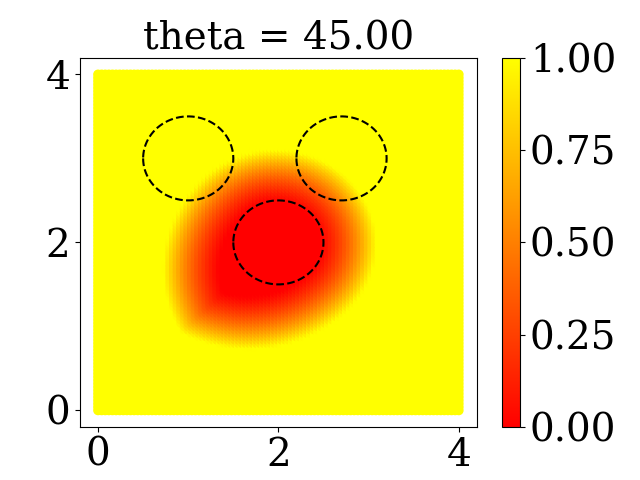

In [27]:
print(f"shape: {tabular_cbf_constraint1.vf_table[:,:,0].shape}")
thetas_value = grid.states[0,1,:,2]
theta_index = int(grid.states.shape[2]/2/4 + grid.states.shape[2]/2) #51 # for 45 degrees
fig7, ax7 = plt.subplots()
ax7.set_title(f"theta = %.2f" %(thetas_value[theta_index]*180/np.pi))
x = np.linspace(0,4, grid.states.shape[0])
y = np.linspace(0,4, grid.states.shape[1]) # grid_resolution = (201, 201, 81)
X, Y = np.meshgrid(x,y)
im7 = ax7.scatter( Y.reshape(-1,1), X.reshape(-1,1), c = tabular_cbf_constraint1.vf_table[:,:,theta_index].reshape(-1,1), cmap='autumn', vmin=0.0, vmax=1.0 )
# im6 = ax6.scatter( Y.reshape(-1,1), X.reshape(-1,1), c = tabular_cbf_hjr.vf_table[:,:,theta_index].reshape(-1,1), cmap='jet', vmin=-1, vmax=1.0 )
fig7.colorbar(im7, ax=ax7)
theta = np.linspace(-np.pi, np.pi, 360)
ax7.plot( obs1[0]+0.5*np.cos(theta), obs1[1]+0.5*np.sin(theta), 'k--', linewidth=1.5 )
ax7.plot( obs2[0]+0.5*np.cos(theta), obs2[1]+0.5*np.sin(theta), 'k--', linewidth=1.5)
ax7.plot( obs3[0]+0.5*np.cos(theta), obs3[1]+0.5*np.sin(theta), 'k--', linewidth=1.5 )
fig7.savefig(name+'refined.png')
plt.show()

In [ ]:
print(f"shape: {tabular_cbf_constraint2.vf_table[:,:,0].shape}")
thetas_value = grid.states[0,1,:,2]
theta_index = int(grid.states.shape[2]/2/4 + grid.states.shape[2]/2) #51 # for 45 degrees
fig8, ax8 = plt.subplots()
ax8.set_title(f"theta = %.2f" %(thetas_value[theta_index]*180/np.pi))
x = np.linspace(0,4, grid.states.shape[0])
y = np.linspace(0,4, grid.states.shape[1]) # grid_resolution = (201, 201, 81)
X, Y = np.meshgrid(x,y)
im8 = ax8.scatter( Y.reshape(-1,1), X.reshape(-1,1), c = tabular_cbf_constraint2.vf_table[:,:,theta_index].reshape(-1,1), cmap='autumn', vmin=0.0, vmax=1.0 )
# im6 = ax6.scatter( Y.reshape(-1,1), X.reshape(-1,1), c = tabular_cbf_hjr.vf_table[:,:,theta_index].reshape(-1,1), cmap='jet', vmin=-1, vmax=1.0 )
fig8.colorbar(im8, ax=ax8)
theta = np.linspace(-np.pi, np.pi, 360)
ax8.plot( obs1[0]+0.5*np.cos(theta), obs1[1]+0.5*np.sin(theta), 'k--', linewidth=1.5 )
ax8.plot( obs2[0]+0.5*np.cos(theta), obs2[1]+0.5*np.sin(theta), 'k--', linewidth=1.5)
ax8.plot( obs3[0]+0.5*np.cos(theta), obs3[1]+0.5*np.sin(theta), 'k--', linewidth=1.5 )
fig8.savefig(name+'refined.png')
plt.show()

In [ ]:
print(f"shape: {tabular_cbf_constraint3.vf_table[:,:,0].shape}")
thetas_value = grid.states[0,1,:,2]
theta_index = int(grid.states.shape[2]/2/4 + grid.states.shape[2]/2) #51 # for 45 degrees
fig9, ax9 = plt.subplots()
ax9.set_title(f"theta = %.2f" %(thetas_value[theta_index]*180/np.pi))
x = np.linspace(0,4, grid.states.shape[0])
y = np.linspace(0,4, grid.states.shape[1]) # grid_resolution = (201, 201, 81)
X, Y = np.meshgrid(x,y)
im9 = ax9.scatter( Y.reshape(-1,1), X.reshape(-1,1), c = tabular_cbf_constraint3.vf_table[:,:,theta_index].reshape(-1,1), cmap='autumn', vmin=0.0, vmax=1.0 )
# im6 = ax6.scatter( Y.reshape(-1,1), X.reshape(-1,1), c = tabular_cbf_hjr.vf_table[:,:,theta_index].reshape(-1,1), cmap='jet', vmin=-1, vmax=1.0 )
fig9.colorbar(im9, ax=ax9)
theta = np.linspace(-np.pi, np.pi, 360)
ax9.plot( obs1[0]+0.5*np.cos(theta), obs1[1]+0.5*np.sin(theta), 'k--', linewidth=1.5 )
ax9.plot( obs2[0]+0.5*np.cos(theta), obs2[1]+0.5*np.sin(theta), 'k--', linewidth=1.5)
ax9.plot( obs3[0]+0.5*np.cos(theta), obs3[1]+0.5*np.sin(theta), 'k--', linewidth=1.5 )
fig9.savefig(name+'refined.png')
plt.show()

In our work, we propose instead initializing with a candidate CBF, as below:

In [75]:
x0 = np.array([0, 0, np.pi / 3])
n_sims_per_start = 1
t_sim = 6

### Setting up the nominal controller
Setting up the nominal controller is non-trivial as outlined in the first section of the notebook

We use HJ reachability instead (but any other nominal controller that can handle non-holonomic constraints, e.g. RRT* could be used)

In [76]:
target = np.array([3, 4, 0])

opt_ctrl = nominal_hjr_control.NominalControlHJNP(dyn_hjr, grid, final_time=-6, time_intervals=101, solver_accuracy="low", 
                                                  target=target, padding=jnp.array([.2, .2, jnp.pi / 6]))

opt_ctrl.solve()
# np.save("dubins/performance_policy_vfs.npy", opt_ctrl.tv_vf)
    
nom_policy = nominal_hjr_control.NominalPolicy(opt_ctrl)

100%|########################################################################################################################|  6.0000/6.0 [00:35<00:00,  5.92s/sim_s]


In [ ]:
nom_policy = nominal_hjr_control.NominalPolicy(opt_ctrl)

### Setting up the safety filter

In [ ]:
alpha = lambda x: 5 * x
# dubins_asif = ControlAffineASIF(dyn, dubins_cbf, alpha=alpha, nominal_policy=nom_policy)
dubins_asif_ws = ControlAffineASIF(dyn, tabular_cbf, alpha=alpha, nominal_policy=nom_policy, umin=umin, umax=umax)

### Rollout different CBFs / nominal controller

In [ ]:
experiment = RolloutTrajectory('dubins', start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)

In [ ]:
import logging
import pandas as pd
logging.getLogger('cbf_opt').setLevel(level=logging.ERROR)  # Surpresses warnings
results_df = experiment.run(dyn, {'Nominal': nom_policy, 'Analytical': dubins_asif, 'Refined': dubins_asif_ws})

### Visualizing the results

In [ ]:
ts_experiment = TimeSeriesExperiment('dubins', start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)
ss_experiment = StateSpaceExperiment('dubins', x_indices=[0, 1], start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)

Next, we remove the part of the trajectory that is beyond the target! (Dubins car can't stabilize so we consider a finite-time reaching scenario)

In [ ]:
updated_df = results_df.copy()
for ctrl in updated_df.controller.unique():
    df = updated_df[(updated_df.controller == ctrl) & (updated_df.measurement == 'dist_to_goal')]
    min_val = df.value.min()
    t_min = df.t.loc[df.value == df.value.min()].values[0]
    condition = updated_df[(updated_df.controller == ctrl) & (updated_df.t > t_min)]
    updated_df = updated_df.drop(condition.index)
updated_df = updated_df.reset_index(drop=True)

## Visualizations for paper + demo + videos

### Figure in paper

In [ ]:
colors = sns.color_palette("tab10")
chosen_colors = [(0.5, 0.5, 0.5)]
chosen_colors.append(colors[0])
chosen_colors.append(colors[1])
chosen_colors.append((0.1, 0.1, 0.1))
chosen_colors.append((0.7, 0.7, 0.7))

colors = [(0.3, 0.3, 0.3)]
colors += [(sns.color_palette("RdYlGn_r", 7)[0])]
colors += [(sns.color_palette("RdYlGn_r", 9)[6])]
colors += [(sns.color_palette("RdYlGn_r", 9)[8])]
colors += [(4 / 255, 101 / 255, 4 / 255)]

alt_colors = sns.color_palette("pastel", 9).as_hex()

In [ ]:
save_figure = False
offset = 0

In [ ]:
fig_comb, axs = plt.subplots(1, 2, figsize=(16, 12 ), sharey=True)
proxy = [] 
ax=axs[0]

cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle[..., offset], 
                 levels=[-10, 0], alpha=0.3, colors='grey')
ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle[..., offset], 
           levels=[0], alpha=0.6, colors='grey', linewidths=2)
cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values_hjr[-1][..., offset], 
                 levels=[0, 50], colors=alt_colors[2], alpha=0.3)
cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], 
                   target_values[0][..., offset], levels=[0], colors=colors, linewidths=6, alpha=0.6)
cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], 
                   target_values[5][..., offset], levels=[0], colors=colors, linewidths=6, alpha=0.4)
cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], 
                   target_values[10][..., offset], levels=[0], colors=colors, linewidths=6, alpha=0.2)
cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], 
                   target_values[-1][..., offset], levels=[0], colors=np.array([colors[-1]]), linewidths=6)

ax.grid()
ax.set_xlabel("$x$ [m]")
ax.set_ylabel('$y$ [m]')
ax.set_xlim([1.5, 6.5])
ax.set_ylim([3, 8])
ax.set_title(r"Iterations of CBF's safe set ($\theta=-\pi / 2$ slice)")
ax = axs[1]
ss_experiment.plot(dyn, updated_df, ax=ax, color=chosen_colors, add_direction=False)
ax.grid(True)
ax.set_xlim([1.5, 6.5])
ax.set_ylim([3, 8])
ax.lines[3].set_linestyle((0, (5, 5, 1, 5)))
pal = sns.color_palette("colorblind")
sns.set_palette("colorblind")

l1 = ax.plot(x0[0], x0[1], 'x', markersize=25, mew=5, color='grey')
l2 = ax.plot(opt_ctrl.target[0], opt_ctrl.target[1], 'o', markersize=25, color='grey', alpha=1)
miscs = [l1, l2]
ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle[..., 0], levels=[-10, 0], 
            colors='grey', alpha=.3)
ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle[..., 0], levels=[0], 
           colors='grey', alpha=.6, linewidths=2)
ax.set_ylabel(None)
ax.set_xlabel("$x$ [m]")
axs[1].set_title('Trajectories with safety filter')
leg = axs[1].legend([misc[0] for misc in miscs], ['Start', 'Goal'], ncol=2, bbox_to_anchor=[.5, 0.05], loc='center', 
                    frameon=True, handletextpad=0.6)
axs[1].legend([ax.lines[0], ax.lines[3], ax.lines[6]], [r"Nominal $(\hat \pi)$", "Candidate CBF", "Converged CBVF"], 
               bbox_to_anchor=[.36, 0.89], ncol=1, columnspacing=1.5, handletextpad=1, loc='center', frameon=True)
axs[1].add_artist(leg)

fig_comb.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0)

if save_figure:
    plt.savefig("dubins.png", dpi=400, bbox_inches='tight')


### Animation of 0-superlevel set

In [ ]:
toggle_hjr_visualization = False
save_video = False
offset = 21

In [ ]:
def render_frame(i, colorbar=False):
    global cont
    for c in cont.collections:
        c.remove()

    timestamp.set_text("Iteration = {}".format(i))
    cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[i][..., offset], levels=[0], 
                      colors=np.array([colors[-1]]))
    if toggle_hjr_visualization:
        global cont2
        for c in cont2.collections:
            c.remove()
        cont2 = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values_hjr[i][..., offset], levels=[0],
                           colors=np.array([chosen_colors[0]]))


filename = "dubins.mp4"
fig, ax = plt.subplots(1, 1, figsize=(18,9 ))

proxy = [] 
obstacle_viz = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], obstacle[..., offset], 
                           levels=[-10, 0], colors='grey', alpha=0.3)

cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values_hjr[-1][..., offset], levels=[0, 50], 
                 colors=alt_colors[2], alpha=0.3)
cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[0][..., offset], levels=[0], 
                  colors=np.array([colors[3]]))
proxy += [plt.Rectangle((0,0),1,1,ec = colors[3], fc='white', lw=5)
        for pc in cont.collections]

timestamp = ax.text(0.05, 0.9, "", transform=ax.transAxes)


cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values[0][..., offset], levels=[0], 
                  colors=np.array([colors[-1]]))
proxy += [plt.Rectangle((0,0),1,1,ec = colors[-1], fc='white', lw=5)
          for pc in cont.collections]
if toggle_hjr_visualization:
    cont2 = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[0], target_values_hjr[0][..., offset], levels=[0], 
                       colors=np.array([chosen_colors[0]]))
    proxy += [plt.Rectangle((0,0),1,1,ec = chosen_colors[0], fc='white', lw=5)
              for pc in cont2.collections]

ax.grid()
ax.set_xlabel("$x$ [m]")
ax.set_xlim([1, 10])
ax.set_ylim([2.5, 8])
ax.set_ylabel("$y$ [m]")

proxy2 = []
proxy2 += [plt.Rectangle((0,0),1,1,fc = alt_colors[2], ec='white', alpha=0.3) for pc in cs.collections]
proxy2 += [plt.Rectangle((0,0),1,1, fc='grey', ec='grey', alpha=0.3) for pc in obstacle_viz.collections]

legend_entries = ["$\partial \mathcal{C}_h$", "$\partial \mathcal{C}_h(t)$"]
if toggle_hjr_visualization:
    legend_entries += ["$\partial \mathcal{C}_{\ell}(t)$"]
leg = ax.legend(proxy, legend_entries, 
          loc='center', bbox_to_anchor=(0.5, 0.9), ncol=3, columnspacing=1.5, handletextpad=0.4)
ax.legend(proxy2, ["Viability kernel $\mathcal{S}^*$", "Obstacle $\mathcal{L}^c$"],
          loc='center', bbox_to_anchor=(0.5, 0.07), ncol=3, columnspacing=1.5, handletextpad=0.4)
ax.add_artist(leg)


render_frame(0, False)
animation = anim.FuncAnimation(fig, render_frame, target_values.shape[0] * 5 // 16, interval=100)

if save_video: 
    animation.save(filename, writer='ffmpeg')